In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import bbknn
import re
import json
import os
import rpy2
import anndata
from datetime import date
from scipy.stats import binom_test
from datetime import datetime

# YYYY-MM-DD
today = date.today()
today = today.strftime("%Y-%m-%d")

import warnings
warnings.filterwarnings('ignore')

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set up

In [2]:
# Check the threshold for binarisation, the ouput is specific to that
threshold=0.1
threshold_for_filename=str(threshold).replace('.','p')
print(threshold_for_filename)

# Confirm the output path
output_path='/nfs/team205/heart/EBI_GWAS/enrichment_output/'

0p1


# Read in output file

In [3]:
combined_output_df=pd.read_csv(f'{output_path}{threshold_for_filename}_all_traits_summary.csv',index_col='cell_type')
combined_output_df['efo_term']=combined_output_df['efo_term'].astype(str)+"_"+combined_output_df['n_SNPs'].astype(str) # Add the n_SNPs - useful for later inspection
combined_output_df

,proportion_of_all_open_peaks_found_in_this_celltype,proportion_of_SNPs_found_in_celltype_specific_open_peaks,mean_proportions_of_SNPs_in_open_peaks,n_times_proportions_of_SNPs_in_permuted_open_peaks_greater_than_observed_proportion,p_value,n_SNPs,efo_id,efo_term
cell_type,,,,,,,,
GreatVesselAdventitialFibroblasts,0.033318,0.0,0.025400,1000,1.0,32,EFO_0000266,aortic stenosis_32
VentricularCardiomyocytesCompact,0.040013,0.0,0.041000,1000,1.0,32,EFO_0000266,aortic stenosis_32
LymphaticEndothelialCells,0.038325,0.0,0.037600,1000,1.0,32,EFO_0000266,aortic stenosis_32
CoronaryEndothelialCellsArterial,0.039600,0.0,0.039000,1000,1.0,32,EFO_0000266,aortic stenosis_32
NaturalKillerCells,0.026457,0.0,0.024800,1000,1.0,32,EFO_0000266,aortic stenosis_32
...,...,...,...,...,...,...,...,...
CoronaryEndothelialCellsCapillary,0.035550,0.0,0.034444,1000,1.0,26,MONDO_0015263,Brugada syndrome_26
MacrophagesCX3CR1pos,0.030999,0.0,0.032222,1000,1.0,26,MONDO_0015263,Brugada syndrome_26
MesothelialEpicardialCells,0.043895,0.0,0.048222,1000,1.0,26,MONDO_0015263,Brugada syndrome_26


<AxesSubplot:>

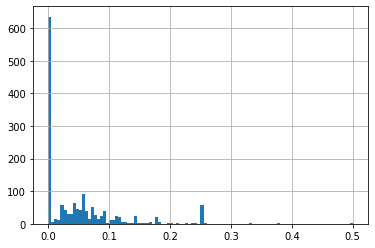

In [4]:
combined_output_df.proportion_of_SNPs_found_in_celltype_specific_open_peaks.hist(bins=100)

In [5]:
#pivot the table to prepare for heatmap
df=combined_output_df[['p_value','efo_term']]
df=df.pivot_table(values='p_value',index='cell_type',columns='efo_term')
df

efo_term,Brugada syndrome_26,JT interval_235,Mitral valve prolapse_36,P wave duration_20,PR interval_467,QRS amplitude_44,QRS complex_73,QRS duration_327,QT interval_592,RR interval_31,...,heart rate variability measurement_61,heart rate_301,hypertension_414,hypertrophic cardiomyopathy_73,idiopathic dilated cardiomyopathy_40,myocardial infarction_346,osteoarthritis_123,pulse pressure measurement_1706,resting heart rate_128,thoracic aortic aneurysm_28
cell_type,,,,,,,,,,,,,,,,,,,,,
AtrialCardiomyocytesLeft,1.000,0.000,1.000,1.0,0.045,1.000,1.000,0.010,0.343,1.0,...,0.215,0.496,0.325,0.024,1.0,0.237,0.469,0.037,0.347,0.158
AtrialCardiomyocytesRight,1.000,0.000,1.000,1.0,0.012,1.000,1.000,0.011,0.390,1.0,...,0.212,0.482,0.349,0.028,1.0,0.461,0.448,0.018,0.136,0.134
AtrioventricularNodeCardiomyocytes,1.000,0.000,1.000,1.0,0.006,1.000,1.000,0.193,0.141,1.0,...,0.255,0.303,0.234,0.039,1.0,0.174,0.571,0.040,0.171,0.153
BCells,1.000,0.534,1.000,1.0,0.698,0.283,0.452,0.839,0.890,1.0,...,1.000,0.698,0.353,0.385,1.0,0.145,0.397,0.097,0.078,1.000
Cardiofibromyocytes,1.000,0.001,1.000,1.0,0.062,1.000,1.000,0.130,0.137,1.0,...,0.161,0.333,0.362,0.011,1.0,0.521,0.395,0.005,0.588,0.095
ChromaffinCells,1.000,0.006,0.392,1.0,0.478,1.000,1.000,0.975,0.568,1.0,...,1.000,0.675,0.244,0.221,1.0,0.267,0.251,0.056,0.260,0.181
CoronaryEndothelialCellsArterial,1.000,0.038,1.000,1.0,0.070,1.000,1.000,0.511,0.784,1.0,...,1.000,1.000,0.197,0.004,1.0,0.142,0.517,0.001,0.400,0.163
CoronaryEndothelialCellsCapillary,1.000,0.077,1.000,1.0,0.098,1.000,1.000,0.687,0.518,1.0,...,1.000,0.787,0.020,0.002,1.0,0.104,0.139,0.003,0.341,0.131
CoronaryEndothelialCellsVenous,1.000,0.108,1.000,1.0,0.111,1.000,1.000,0.472,0.707,1.0,...,1.000,0.797,0.066,0.111,1.0,0.213,0.137,0.034,0.130,0.141


In [6]:
# drop columns where p value is all 1 (i.e. nothing at all significant)
print(df.shape)
df=df.loc[:, (df != 1).any(axis=0)]
print(df.shape)

(44, 34)
(44, 30)


In [7]:
# multiple testing correction
import statsmodels.stats.multitest
from statsmodels.stats.multitest import multipletests

method='fdr_bh'
columns=df.columns.tolist()

# correct for multiple testing (each test being one cell type). Replacing the column with a corrected value
for column in columns:
    df[column]=statsmodels.stats.multitest.multipletests(df[column],method=method)[1]
df.head()

efo_term,Brugada syndrome_26,JT interval_235,Mitral valve prolapse_36,PR interval_467,QRS amplitude_44,QRS complex_73,QRS duration_327,QT interval_592,aortic measurement_285,aortic root size_21,...,heart rate response to recovery post exercise_65,heart rate variability measurement_61,heart rate_301,hypertension_414,hypertrophic cardiomyopathy_73,myocardial infarction_346,osteoarthritis_123,pulse pressure measurement_1706,resting heart rate_128,thoracic aortic aneurysm_28
cell_type,,,,,,,,,,,,,,,,,,,,,
AtrialCardiomyocytesLeft,1.0,0.000000,1.0,0.195250,1.0,1.0,0.069143,0.884000,0.895349,1.0,...,0.551886,1.0,0.9229,0.421474,0.077000,0.372114,0.639048,0.056138,0.462667,0.214211
AtrialCardiomyocytesRight,1.0,0.000000,1.0,0.066000,1.0,1.0,0.069143,0.884000,0.895349,1.0,...,0.551886,1.0,0.9229,0.421474,0.077000,0.520103,0.639048,0.037714,0.462667,0.214211
AtrioventricularNodeCardiomyocytes,1.0,0.000000,1.0,0.037714,1.0,1.0,0.772000,0.664400,0.895349,1.0,...,0.551886,1.0,0.9229,0.363355,0.081714,0.372114,0.639048,0.058667,0.462667,0.214211
BCells,1.0,0.573073,1.0,0.749073,1.0,1.0,0.984098,0.910698,0.895349,1.0,...,1.000000,1.0,0.9229,0.421474,0.470556,0.372114,0.639048,0.112316,0.462667,1.000000
Cardiofibromyocytes,1.0,0.004400,1.0,0.195250,1.0,1.0,0.572000,0.664400,0.895349,1.0,...,0.551886,1.0,0.9229,0.421474,0.077000,0.573100,0.639048,0.015714,0.646800,0.214211


efo_term,Brugada syndrome_26,JT interval_235,Mitral valve prolapse_36,PR interval_467,QRS amplitude_44,QRS complex_73,QRS duration_327,QT interval_592,aortic measurement_285,aortic root size_21,...,heart rate response to recovery post exercise_65,heart rate variability measurement_61,heart rate_301,hypertension_414,hypertrophic cardiomyopathy_73,myocardial infarction_346,osteoarthritis_123,pulse pressure measurement_1706,resting heart rate_128,thoracic aortic aneurysm_28
cell_type,,,,,,,,,,,,,,,,,,,,,
AtrialCardiomyocytesLeft,0.0,1.356547,0.0,0.709409,0.0,0.0,1.160253,0.053548,0.048008,0.0,...,0.258151,0.0,0.034845,0.375230,1.113509,0.429324,0.194467,1.250744,0.334732,0.669159
AtrialCardiomyocytesRight,0.0,1.356547,0.0,1.180456,0.0,0.0,1.160253,0.053548,0.048008,0.0,...,0.258151,0.0,0.034845,0.375230,1.113509,0.283911,0.194467,1.423494,0.334732,0.669159
AtrioventricularNodeCardiomyocytes,0.0,1.356547,0.0,1.423494,0.0,0.0,0.112383,0.177570,0.048008,0.0,...,0.258151,0.0,0.034845,0.439669,1.087702,0.429324,0.194467,1.231609,0.334732,0.669159
BCells,0.0,0.241790,0.0,0.125476,0.0,0.0,0.006962,0.040626,0.048008,0.0,...,0.000000,0.0,0.034845,0.375230,0.327389,0.429324,0.194467,0.949559,0.334732,0.000000
Cardiofibromyocytes,0.0,2.356547,0.0,0.709409,0.0,0.0,0.242604,0.177570,0.048008,0.0,...,0.258151,0.0,0.034845,0.375230,1.113509,0.241770,0.194467,1.803705,0.189230,0.669159


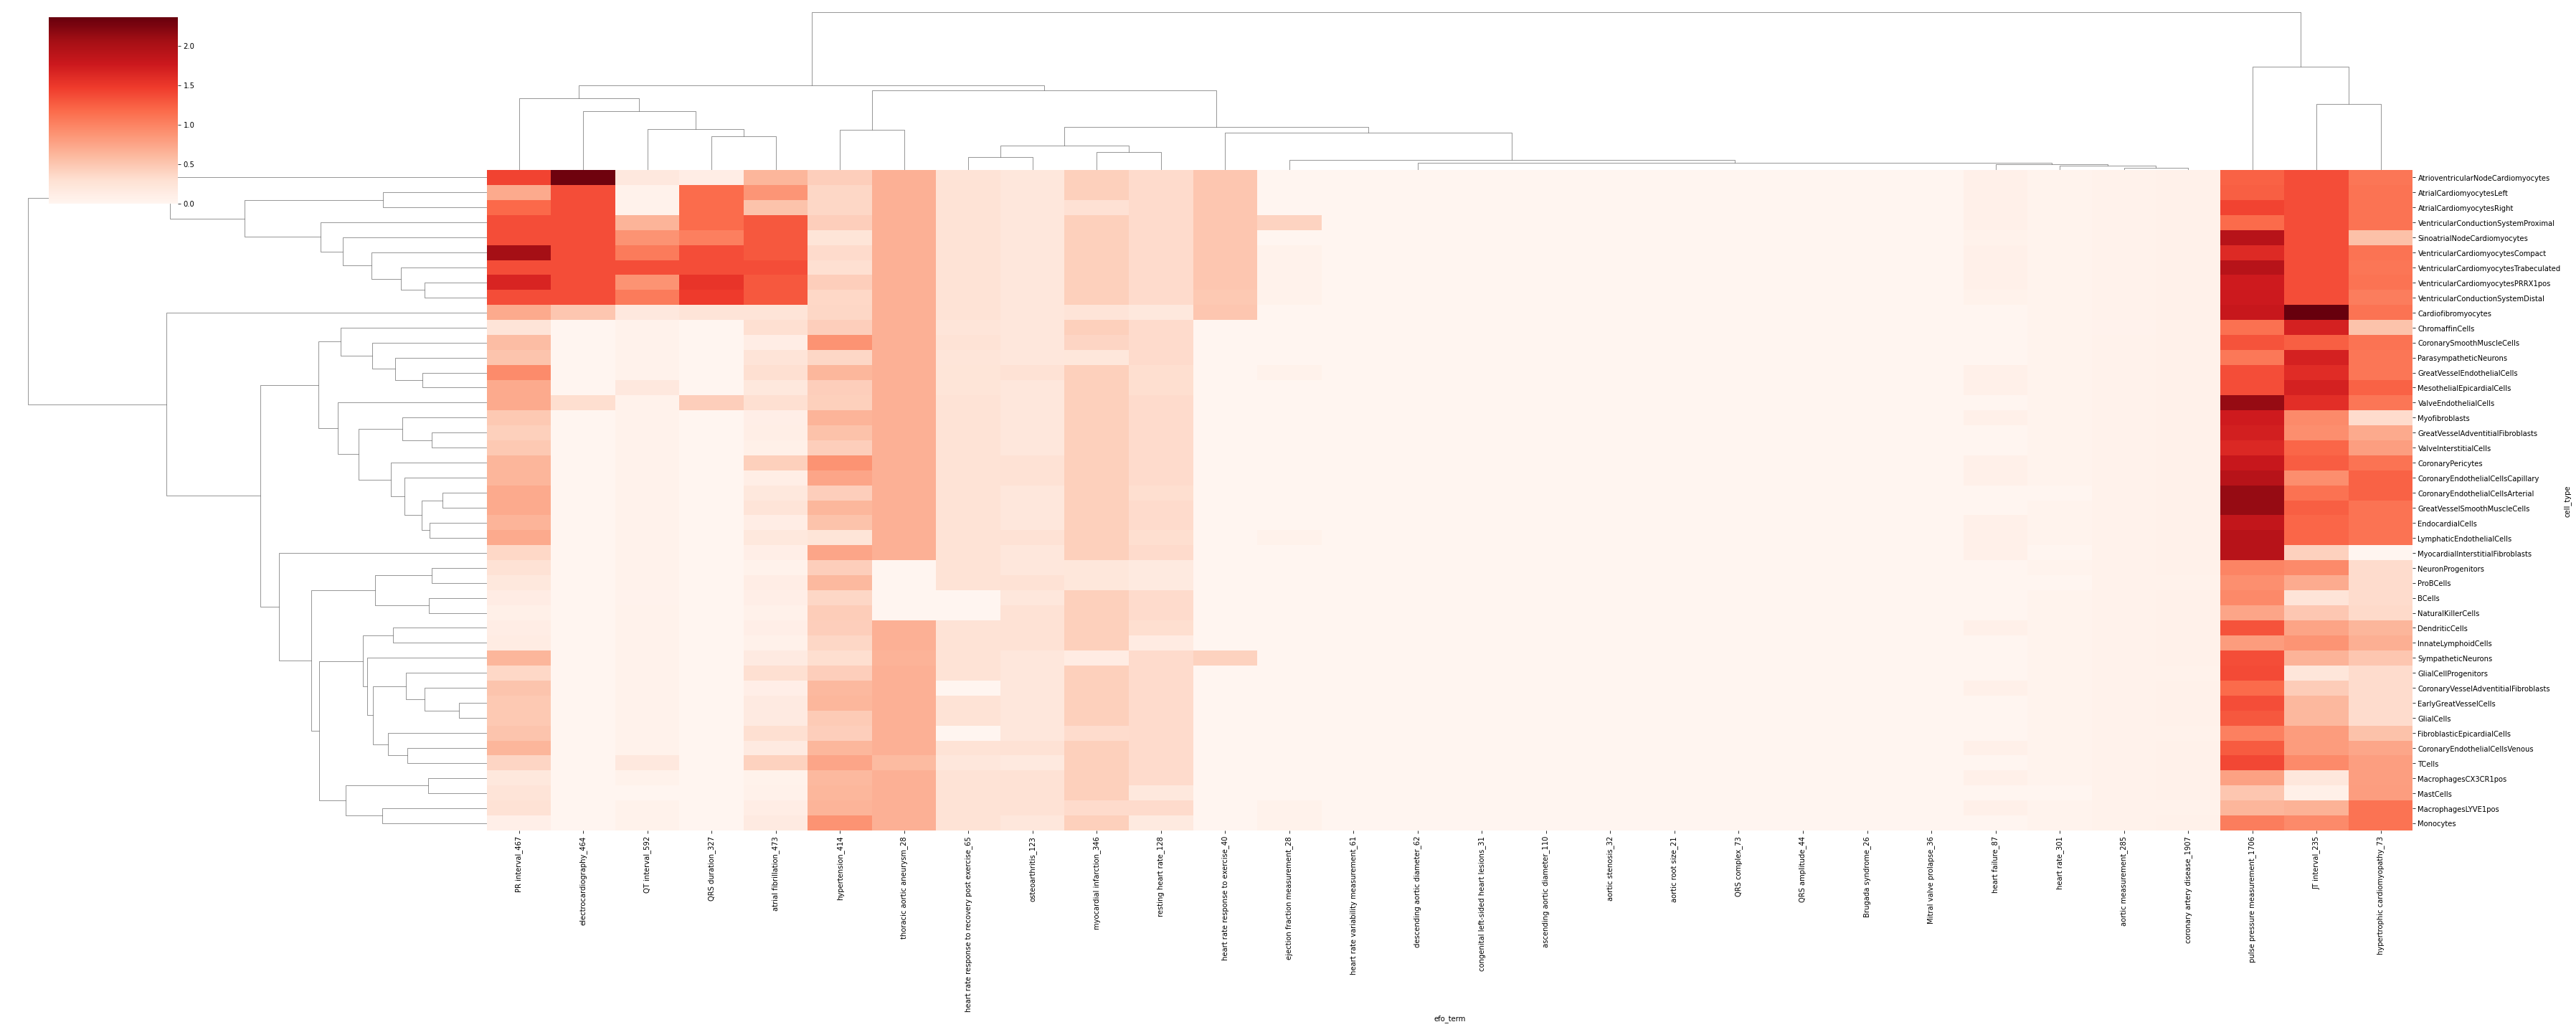

In [8]:
# log-neg transform, then plot

df=np.negative(np.log10(df))
df[df == -0] = 0 # replace '-0' with '0'
df.replace(to_replace=[np.inf, -np.inf], value='inf', inplace=True) # replace infinities with something sensible (the maximum real number found elsewhere in the df)
df.replace(to_replace='inf', value=df.max().max(), inplace=True)

sns.clustermap(df,xticklabels=True,yticklabels=True,cmap='Reds',figsize=(50,20))

df.head()

efo_term,JT interval_235,PR interval_467,QRS duration_327,QT interval_592,aortic measurement_285,atrial fibrillation_473,coronary artery disease_1907,ejection fraction measurement_28,electrocardiography_464,heart failure_87,heart rate response to exercise_40,heart rate response to recovery post exercise_65,heart rate_301,hypertension_414,hypertrophic cardiomyopathy_73,myocardial infarction_346,osteoarthritis_123,pulse pressure measurement_1706,resting heart rate_128,thoracic aortic aneurysm_28
cell_type,,,,,,,,,,,,,,,,,,,,
AtrialCardiomyocytesLeft,1.356547,0.709409,1.160253,0.053548,0.048008,0.859223,0.063383,0.0,1.356547,0.068746,0.50461,0.258151,0.034845,0.375230,1.113509,0.429324,0.194467,1.250744,0.334732,0.669159
AtrialCardiomyocytesRight,1.356547,1.180456,1.160253,0.053548,0.048008,0.532639,0.063383,0.0,1.356547,0.068746,0.50461,0.258151,0.034845,0.375230,1.113509,0.283911,0.194467,1.423494,0.334732,0.669159
AtrioventricularNodeCardiomyocytes,1.356547,1.423494,0.112383,0.177570,0.048008,0.626169,0.063383,0.0,2.310790,0.068746,0.50461,0.258151,0.034845,0.439669,1.087702,0.429324,0.194467,1.231609,0.334732,0.669159
BCells,0.241790,0.125476,0.006962,0.040626,0.048008,0.099858,0.063383,0.0,0.000000,0.000000,0.00000,0.000000,0.034845,0.375230,0.327389,0.429324,0.194467,0.949559,0.334732,0.000000
Cardiofibromyocytes,2.356547,0.709409,0.242604,0.177570,0.048008,0.244366,0.063383,0.0,0.505289,0.000000,0.50461,0.258151,0.034845,0.375230,1.113509,0.241770,0.194467,1.803705,0.189230,0.669159


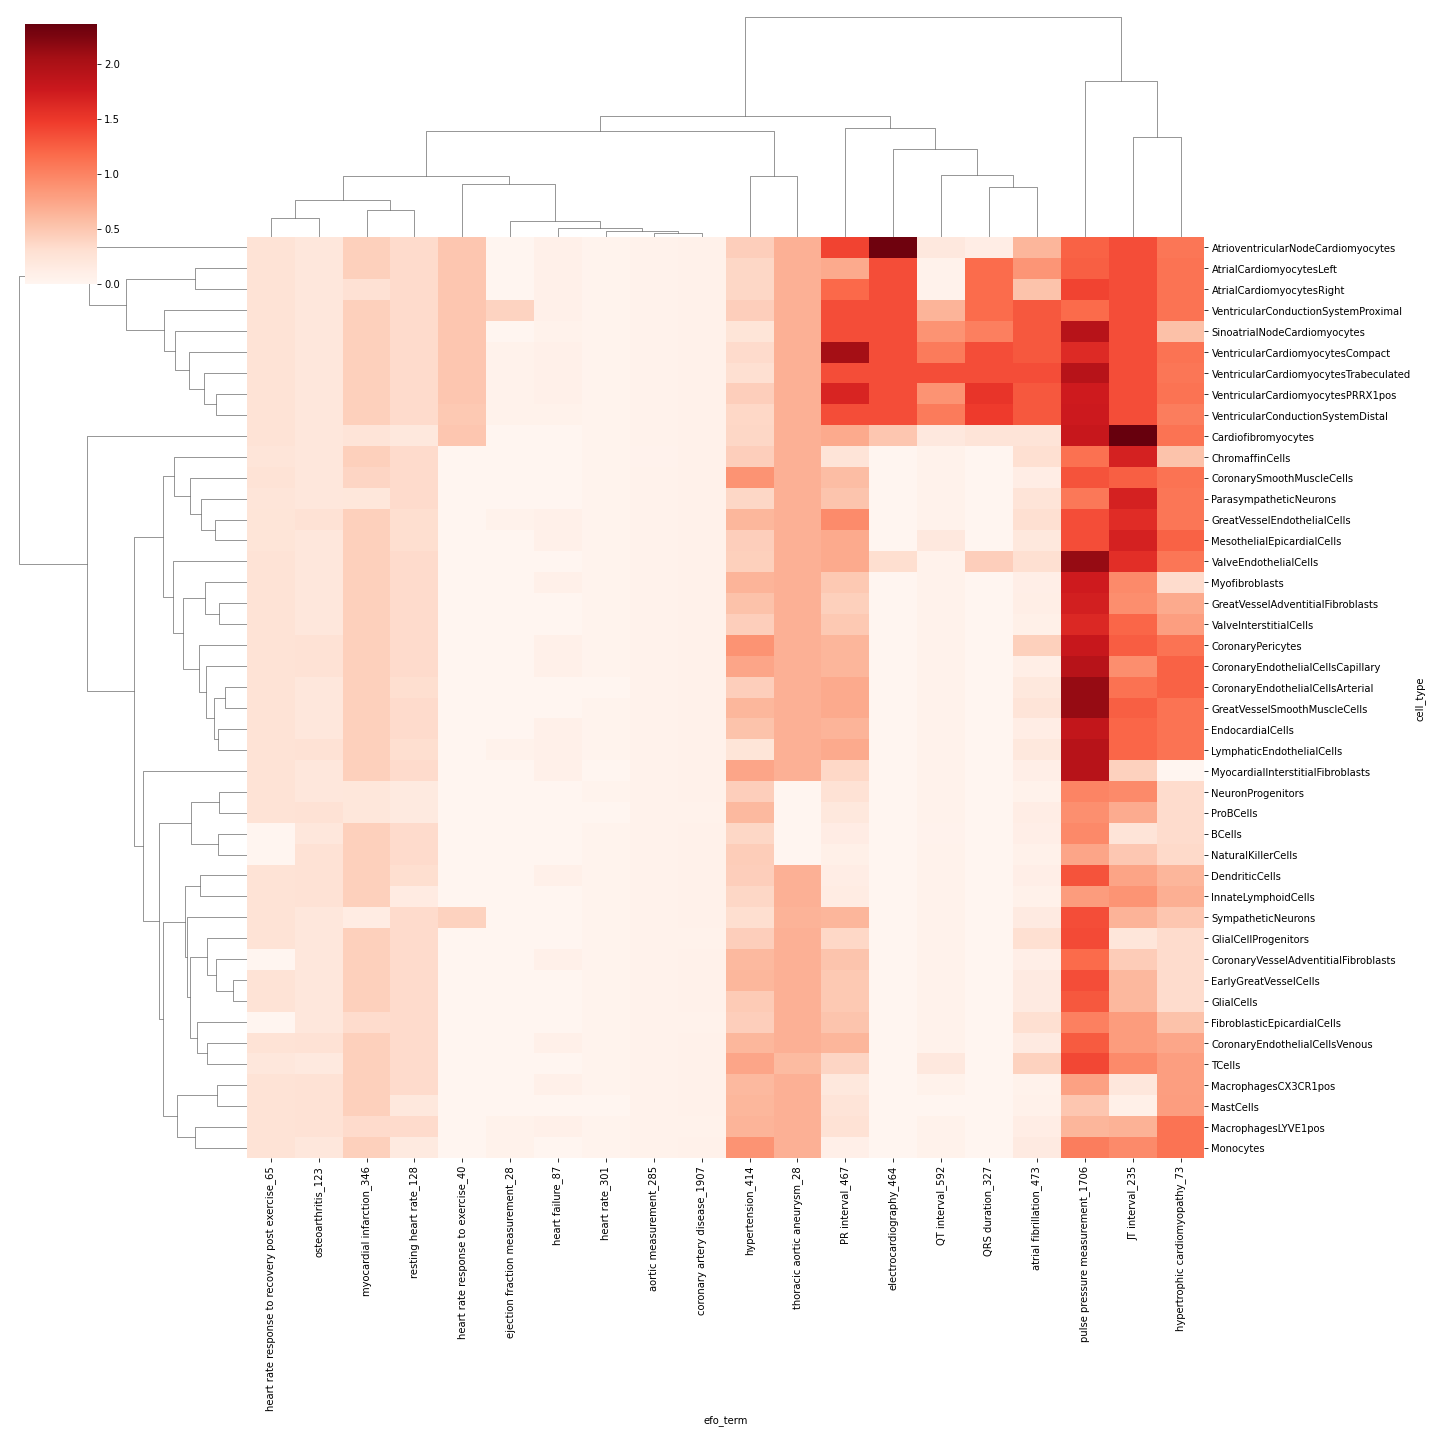

In [9]:
# remove any columns (traits) where all log-neg pvalues are 0
df = df.loc[:, (df != 0).any(axis=0)]

sns.clustermap(df,xticklabels=True,yticklabels=True,cmap='Reds',figsize=(20,20))

df.head()

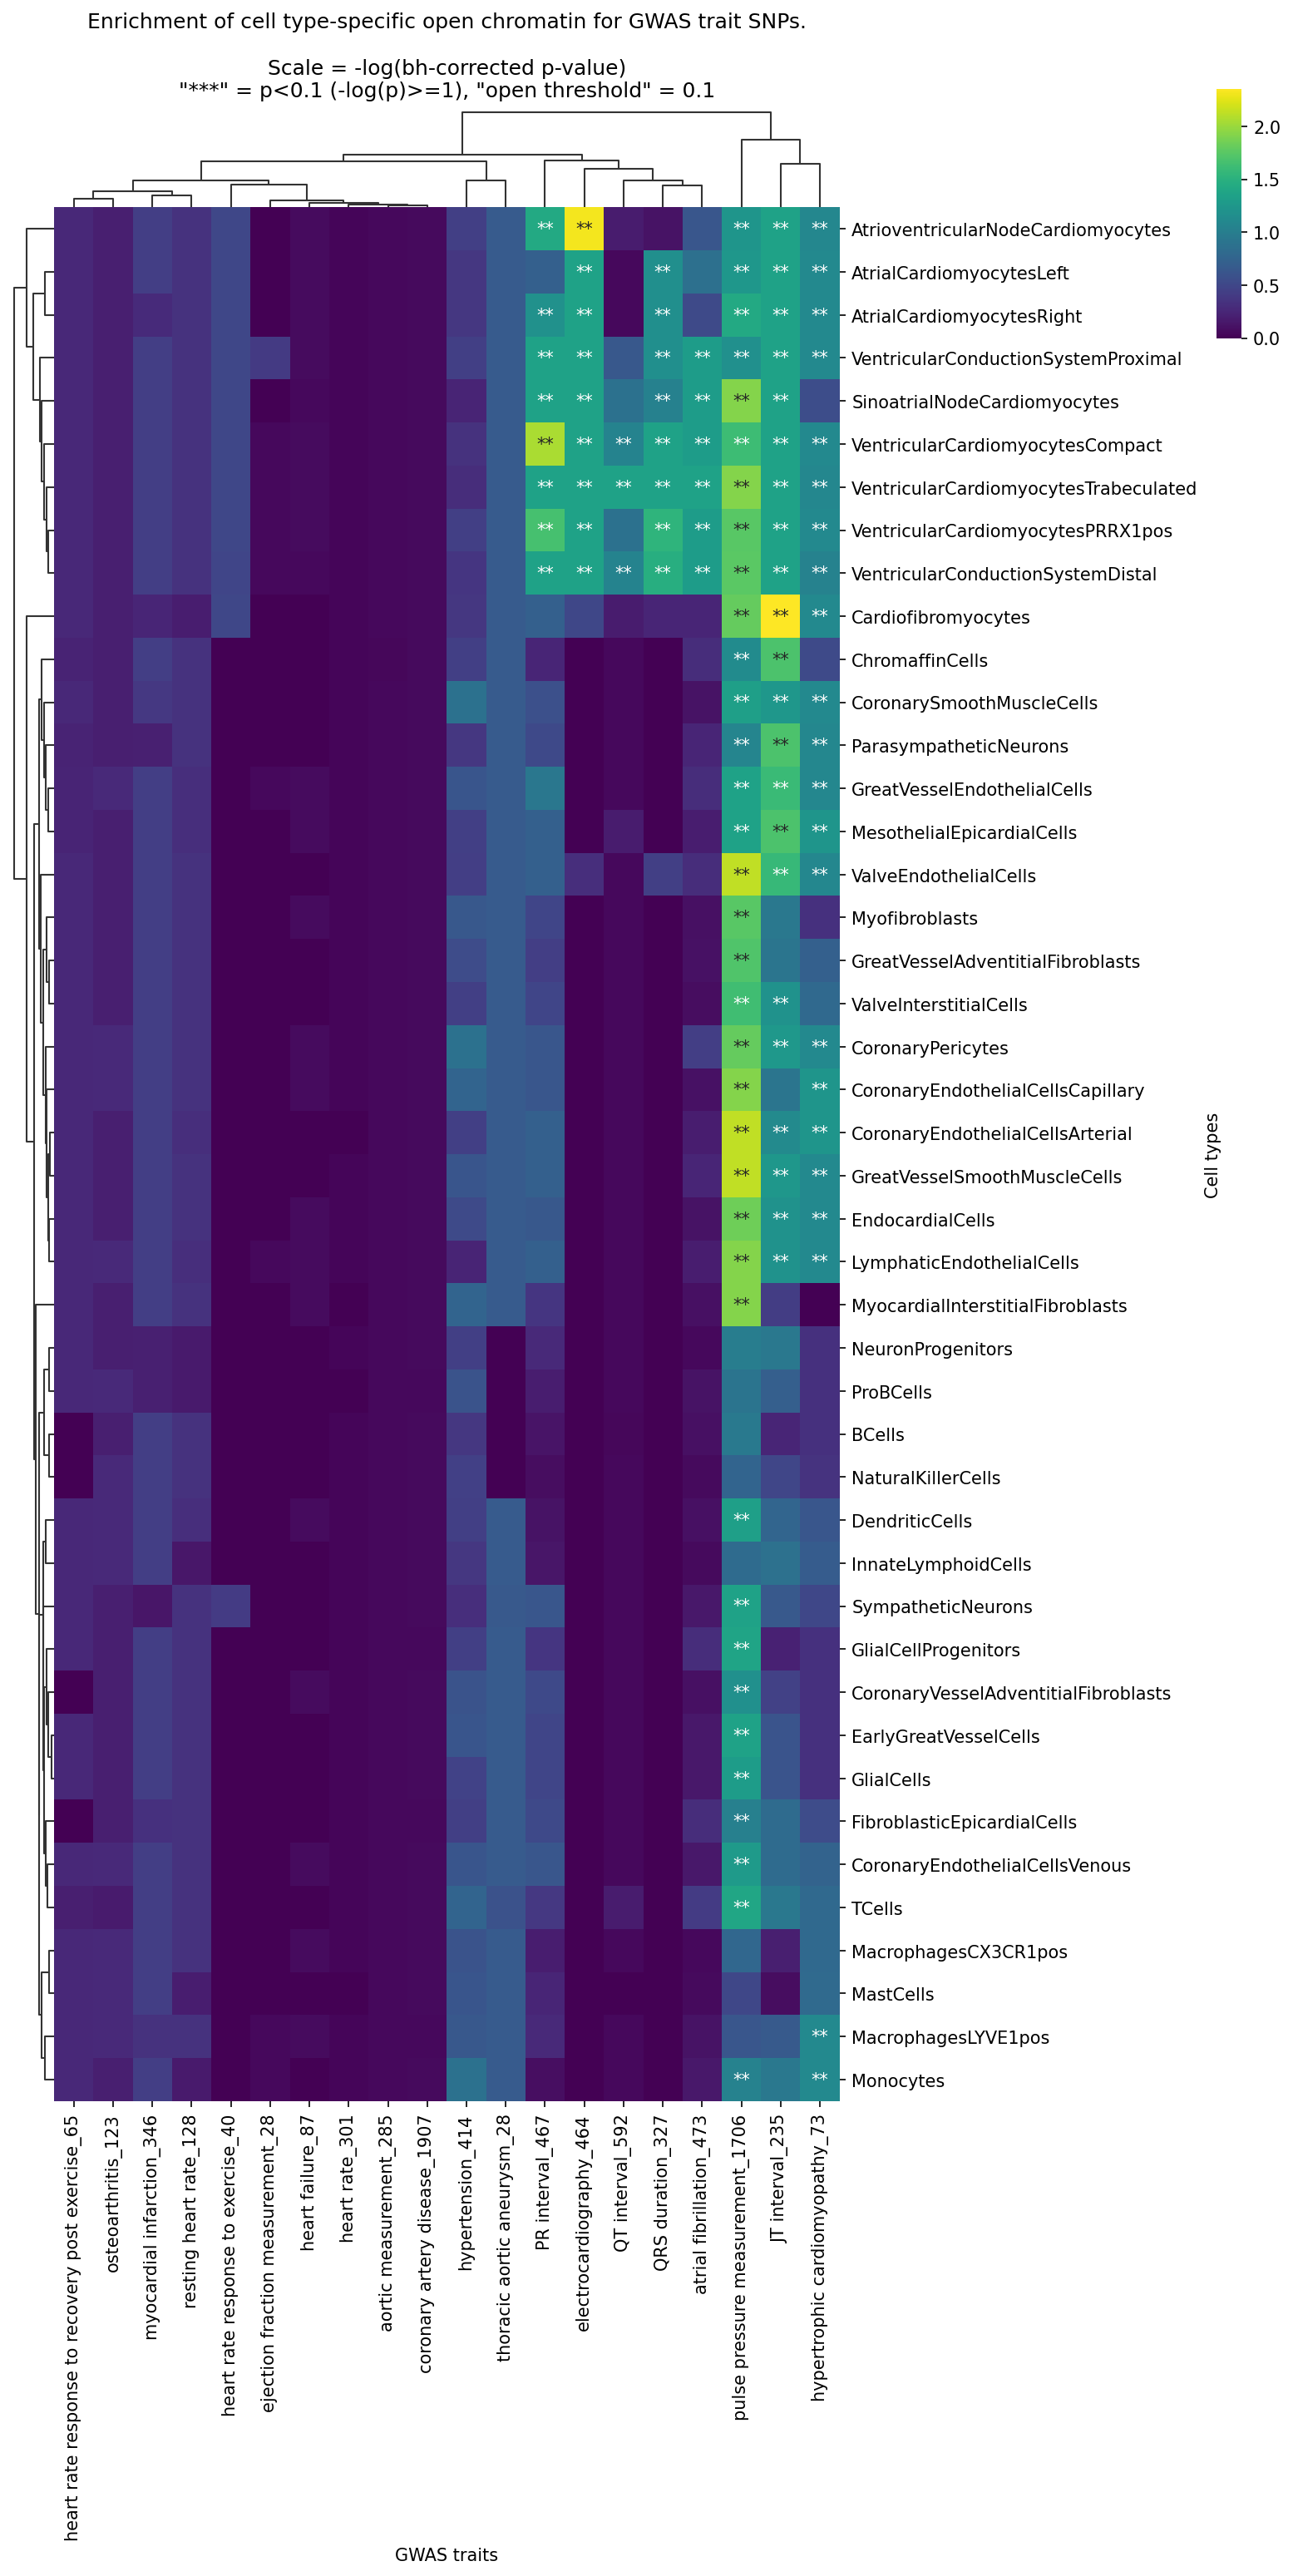

In [14]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 150


# Make annotation df
anno_df=df.where(df<1, other="**")
anno_df=anno_df.where(anno_df=='**', other=" ")
anno_df=anno_df.astype(str)


g=sns.clustermap(df,
               xticklabels=True,
               yticklabels=True,
               cmap='viridis',
               figsize=(10,20),
               annot=anno_df,
               fmt = '',
               dendrogram_ratio=0.05,
               cbar_pos=(0.98,0.9,0.02,0.1),
              )

g.ax_col_dendrogram.set_title(f'Enrichment of cell type-specific open chromatin for GWAS trait SNPs.\n\nScale = -log(bh-corrected p-value)\n"***" = p<0.1 (-log(p)>=1), "open threshold" = {threshold}')

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)
    
ax = g.ax_heatmap
ax.set_xlabel('GWAS traits')
ax.set_ylabel('Cell types')
plt.savefig(f'{output_path}_overview_heatmap_{threshold_for_filename}_SNP_enrichment.png')
plt.show()